# VAE implementation with Tensorflow for MNIST dataset

This is a copy of the vae_tf.py from the GAN and VAE course but with additional comments 

Goal: for personal learning of VAE on the reconstruction of MNIST dataset digit images  

https://deeplearningcourses.com/c/deep-learning-gans-and-variational-autoencoders
https://www.udemy.com/deep-learning-gans-and-variational-autoencoders

In [2]:
from __future__ import print_function, division
from builtins import range, input
# Note: you may need to update your version of future
# sudo pip install -U future

import util
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

st = None
try:
    st = tf.contrib.bayesflow.stochastic_tensor
except:
    # doesn't exist in later versions of TF
    # we will use the reparameterization trick instead
    # watch the later lecture on the reparameterization trick
    # to learn about it.
    pass

# get normal and bernoulli distributions from tensorflow
Normal = tf.contrib.distributions.Normal
Bernoulli = tf.contrib.distributions.Bernoulli

## Notes about the mnist dataset:

- It's meant to be a dataset of 70000 images of 28 * 28 pixels (784 pixels).


- In the edited current dataset, it has 48000 samples for training data and 28000 samples for test data.
- Each sample is a row in the csv file.
- Each column is a 'feature' which is actually just the pixel, with 784 pixels.
- Each value is a RGB code from 0 to 255. 


- In the util.py, the get_mnist function will divide every single pixel value by 255 to get a value from 0 to 1, thus grayscaling the whole dataset.




In [3]:
# construct the Dense Layer class for forward passing 

class DenseLayer(object):
    def __init__(self, M1, M2, f = tf.nn.relu):
#         self.M1 = M1
#         self.M2 = M2
        self.W = tf.Variable(tf.random_normal(shape=(M1, M2)) * 2 / np.sqrt(M1))
        self.b = tf.Variable(np.zeros(M2).astype(np.float32))
        self.f = f # activation function 
    
    def forward(self, X):
        return self.f(tf.matmul(X, self.W) + self.b) 
    # simple weight mult and add bias vector then apply activation function


In [4]:
# construct the Variational Autoencoder class 

class VariationalAutoencoder:
    def __init__(self, D, hidden_layer_sizes):
        # D is the input dimension
        
        # hidden_layer_sizes specifies the size of every layer
        # in the encoder
        # up to the final hidden layer Z
        
        # the decoder will have the reverse shape of the encoder 

        # create a placeholder for input data: represents a batch of training data
        self.X = tf.placeholder(tf.float32, shape=(None, D))

        # 1. Create the layers of the Encoder
        self.encoder_layers = []
        M_in = D
        
        # * ALL hidden layers except final layer in encoder 
        for M_out in hidden_layer_sizes[:-1]:
            h = DenseLayer(M_in, M_out) # create the dense layer for every layer in the encoder hidden layers 
            self.encoder_layers.append(h)
            M_in = M_out # this is to ensure every layer has the row dimension that matches the previous layer 

        # for convenience, we'll refer to the final encoder size as M
        # also the input to the decoder size
        M = hidden_layer_sizes[-1]

        # * FINAL Layer in encoder 
        # the encoder's final layer output is unbounded
        # so there is no activation function
        # we also need 2 times as many units as specified by M_out
        # since there needs to be M_out means + M_out variances 
        h = DenseLayer(M_in, 2 * M, f=lambda x: x) 
        self.encoder_layers.append(h)

        # get the mean and variance / std dev of Z.
        # note that the variance must be > 0
        # we can get a sigma (standard dev) > 0 from an unbounded variable by
        # passing it through the softplus function.
        
        current_layer_value = self.X
        for layer in self.encoder_layers:
            current_layer_value = layer.forward(current_layer_value)
        self.means = current_layer_value[:, :M]
        self.stddev = tf.nn.softplus(current_layer_value[:, M:]) + 1e-6 
        # add a small amount for smoothing (so it's not too close to 0) so we dont get to singularity 

        
        # 2. DRAW a sample of Z
        # we need to use a stochastic tensor
        # in order for the errors to be backpropagated past this point
        if st is None:
          # doesn't exist in later versions of Tensorflow
          # we'll use the same trick we use in Theano
            standard_normal = Normal(
                loc = np.zeros(M, dtype=np.float32),
                scale = np.ones(M, dtype=np.float32)
          )
            e = standard_normal.sample(tf.shape(self.means)[0])
            self.Z = e * self.stddev + self.means

          # note: this also works because Tensorflow
          # now does the "magic" for you
          # n = Normal(
          #   loc=self.means,
          #   scale=self.stddev,
          # )
          # self.Z = n.sample()
        else:
            with st.value_type(st.SampleValue()):
                self.Z = st.StochasticTensor(Normal(loc=self.means, scale=self.stddev))
                # to get back Q(Z), the distribution of Z
                # we will later use self.Z.distribution

###################################

        # 3. Create the layers of the decoder
    
        self.decoder_layers = []
        M_in = M
        for M_out in reversed(hidden_layer_sizes[:-1]): # reversed to be opposite shape of the encoder 
            h = DenseLayer(M_in, M_out)
            self.decoder_layers.append(h)
            M_in = M_out

        # the decoder's final layer should technically go through a sigmoid
        # so that the final output is a binary probability (e.g. Bernoulli)
        # but Bernoulli accepts logits (pre-sigmoid) so we will take those
        # so no activation function is needed at the final layer
        h = DenseLayer(M_in, D, f=lambda x: x)
        self.decoder_layers.append(h)

        # get the logits
        current_layer_value = self.Z
        for layer in self.decoder_layers:
            current_layer_value = layer.forward(current_layer_value)
        logits = current_layer_value
        posterior_predictive_logits = logits # save for later

        # get the output
        self.X_hat_distribution = Bernoulli(logits=logits)

    
        # 4. DRAW samples from X_hat
        # we will call this the ** posterior predictive sample **
        self.posterior_predictive = self.X_hat_distribution.sample()
        self.posterior_predictive_probs = tf.nn.sigmoid(logits)

        # take sample from a Z ~ N(0, 1) --> standard normal 
        # and put it through the decoder
        # we will call this the ** prior predictive sample **
        standard_normal = Normal(
            loc=np.zeros(M, dtype=np.float32),
            scale=np.ones(M, dtype=np.float32)
        )

        Z_std = standard_normal.sample(1)
        current_layer_value = Z_std
        for layer in self.decoder_layers:
            current_layer_value = layer.forward(current_layer_value)
        logits = current_layer_value

        prior_predictive_dist = Bernoulli(logits=logits)
        self.prior_predictive = prior_predictive_dist.sample()
        self.prior_predictive_probs = tf.nn.sigmoid(logits)

        # prior predictive from input
        # only used for generating visualization
        self.Z_input = tf.placeholder(tf.float32, shape=(None, M))
        current_layer_value = self.Z_input
        for layer in self.decoder_layers:
            current_layer_value = layer.forward(current_layer_value)
        logits = current_layer_value
        self.prior_predictive_from_input_probs = tf.nn.sigmoid(logits)

###################################

        # 5. Build the cost: Expected log-likelihood + KL divergence 
        
        # part 2: KL divergence
        if st is None:
            kl = -tf.log(self.stddev) + 0.5*(self.stddev**2 + self.means**2) - 0.5
            kl = tf.reduce_sum(kl, axis=1) 
            # summing across axis=1 because output is M x D matrix, so we want KL divergence per sample
        else:
            kl = tf.reduce_sum(
                tf.contrib.distributions.kl_divergence(
                    self.Z.distribution, standard_normal
                ),
                1 
            )
            
        # part 1: log-likelihood
        expected_log_likelihood = tf.reduce_sum(
            self.X_hat_distribution.log_prob(self.X), 1
        )

        # equivalent code: 
        # expected_log_likelihood = -tf.nn.sigmoid_cross_entropy_with_logits(
        #   labels=self.X,
        #   logits=posterior_predictive_logits
        # )
        # expected_log_likelihood = tf.reduce_sum(expected_log_likelihood, 1)


        # finally get the "Cost" ELBO
        self.elbo = tf.reduce_sum(expected_log_likelihood - kl)
        self.train_op = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(-self.elbo)

        # set up session and variables for later
        self.init_op = tf.global_variables_initializer()
        self.sess = tf.InteractiveSession()
        self.sess.run(self.init_op)

###################################

    # fit function for each batch across all epochs 
    
    def fit(self, X, epochs=30, batch_sz=64):
        costs = []
        n_batches = len(X) // batch_sz
        print("n_batches:", n_batches)
        for i in range(epochs):
            print("epoch:", i)
            np.random.shuffle(X)
            for j in range(n_batches):
                batch = X[j*batch_sz:(j+1)*batch_sz]
                _, c, = self.sess.run((self.train_op, self.elbo), feed_dict={self.X: batch})
                c /= batch_sz # just debugging
                costs.append(c)
                if j % 100 == 0:
                    print("iter: %d, cost: %.3f" % (j, c))
        plt.plot(costs)
        plt.show()

###################################

    # transform function to maps input X to corresponding latent vector Z

    def transform(self, X):
        return self.sess.run(
          self.means,
          feed_dict={self.X: X}
        )

###################################

    # 3 functions for the 3 operations above 
    
    def prior_predictive_with_input(self, Z):
        return self.sess.run(
          self.prior_predictive_from_input_probs,
          feed_dict={self.Z_input: Z}
        )

    def posterior_predictive_sample(self, X):
        # returns a sample from p(x_new | X)
        return self.sess.run(self.posterior_predictive, feed_dict={self.X: X})

    def prior_predictive_sample_with_probs(self):
        # returns a sample from p(x_new | z), z ~ N(0, 1)
        return self.sess.run((self.prior_predictive, self.prior_predictive_probs))



In [6]:
## Main 

# get mnist data first 
X, Y = util.get_mnist()
# convert X to binary varible 
X = (X>0.5).astype(np.float32)


Reading in and transforming data...


C:\Users\pengf\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\client\session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


n_batches: 656
epoch: 0
iter: 0, cost: -1582.131
iter: 100, cost: -258.318
iter: 200, cost: -208.757
iter: 300, cost: -198.003
iter: 400, cost: -184.849
iter: 500, cost: -178.003
iter: 600, cost: -162.546
epoch: 1
iter: 0, cost: -167.464
iter: 100, cost: -164.342
iter: 200, cost: -151.525
iter: 300, cost: -154.335
iter: 400, cost: -154.765
iter: 500, cost: -147.067
iter: 600, cost: -140.343
epoch: 2
iter: 0, cost: -150.958
iter: 100, cost: -147.812
iter: 200, cost: -134.884
iter: 300, cost: -149.189
iter: 400, cost: -142.283
iter: 500, cost: -125.924
iter: 600, cost: -130.569
epoch: 3
iter: 0, cost: -137.986
iter: 100, cost: -138.014
iter: 200, cost: -141.533
iter: 300, cost: -126.877
iter: 400, cost: -128.257
iter: 500, cost: -126.934
iter: 600, cost: -130.496
epoch: 4
iter: 0, cost: -129.049
iter: 100, cost: -124.235
iter: 200, cost: -123.341
iter: 300, cost: -129.485
iter: 400, cost: -125.437
iter: 500, cost: -121.692
iter: 600, cost: -118.539
epoch: 5
iter: 0, cost: -117.771
iter: 

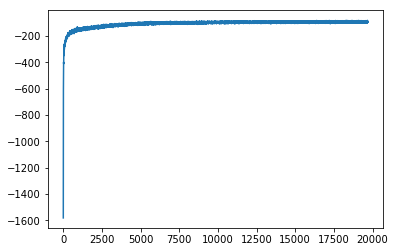

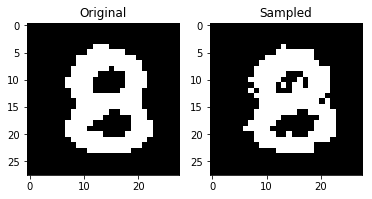

Do you want to generate another? 


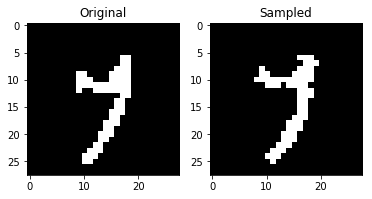

Do you want to generate another? 


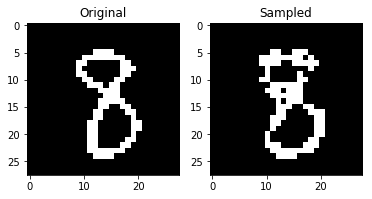

Do you want to generate another? 


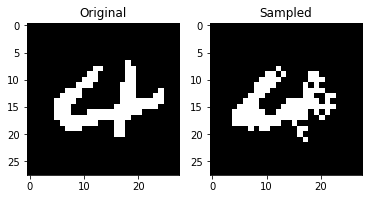

Do you want to generate another? 


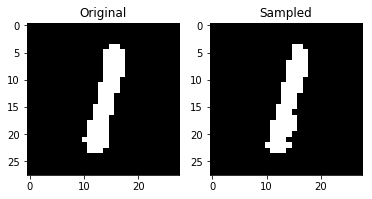

Do you want to generate another? 


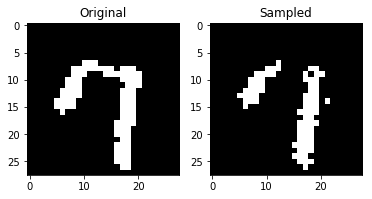

Do you want to generate another? 


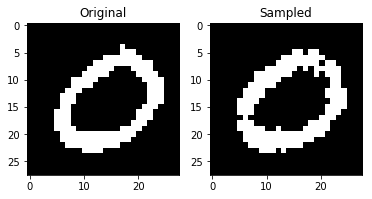

Do you want to generate another? n


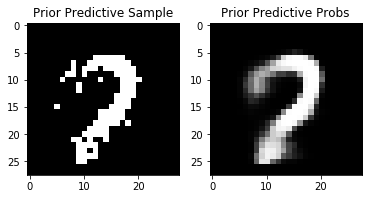

Do you want to generate another? 


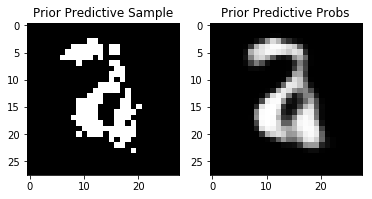

Do you want to generate another? 


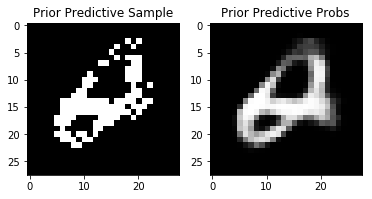

Do you want to generate another? 


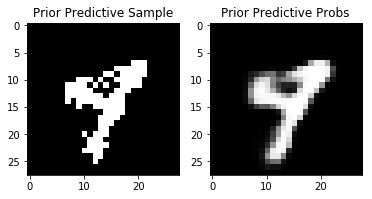

Do you want to generate another? 


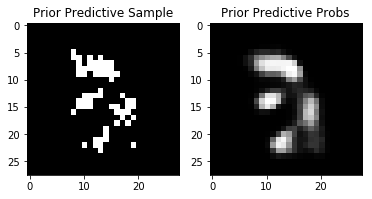

Do you want to generate another? 


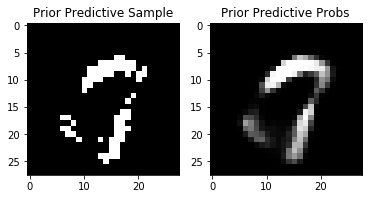

Do you want to generate another? 


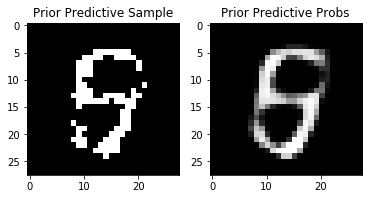

Do you want to generate another? 


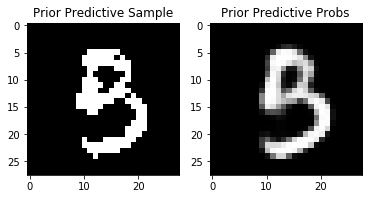

Do you want to generate another? 


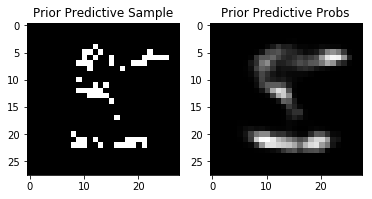

Do you want to generate another? n


In [8]:
# create VAE of 784 inputs (D) and two hidden layers of sizes 200 and 100 respectively
# encoder will have 2 hidden layers 200 and 100 
# decoder is the reversed

vae = VariationalAutoencoder(784, [200,200])
vae.fit(X) 

# 1. Plot reconstructions of randomly selected data points from the training set 
done = False
while not done:
    i = np.random.choice(len(X))
    x = X[i]
    image = vae.posterior_predictive_sample([x]).reshape(28,28) 
    # sample using posterior 
    # reshape to 28 * 28 grid 
    
    plt.subplot(1,2,1)
    plt.imshow(x.reshape(28,28), cmap = 'gray')
    plt.title("Original")
    plt.subplot(1,2,2)
    plt.imshow(image, cmap='gray')
    plt.title("Sampled")
    plt.show()
    
    ans = input("Do you want to generate another? ")
    if ans and ans[0] in ('n' or 'N'):
        done = True

# 2. Plot output from random samples in the latent space  
done = False
while not done:
    image, probs = vae.prior_predictive_sample_with_probs()
    # sample using posterior from the standard normal
    # thus there is no input for this
    
    image = image.reshape(28,28)
    probs = probs.reshape(28,28)

    plt.subplot(1,2,1)
    plt.imshow(image, cmap = 'gray')
    plt.title("Prior Predictive Sample")
    plt.subplot(1,2,2)
    plt.imshow(probs, cmap='gray')
    plt.title("Prior Predictive Probs")
    plt.show()
    
    ans = input("Do you want to generate another? ")
    if ans and ans[0] in ('n' or 'N'):
        done = True


In [11]:
# notice the cost is actually negative for ELBO. So what we are trying to do 
# is to minimize the absolute value to as close to 0 as possible, just like normal cost function minimizations

## Summary 

- Variational autoencoders combine techniques from deep learning and variational inference. 

Two tasks:
1. Reconstruct input 
2. Bottleneck causes the autoencoder to learn compact and efficient representation of data




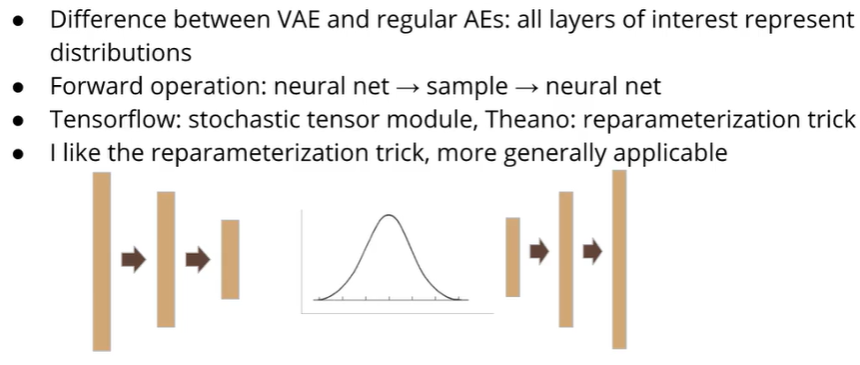

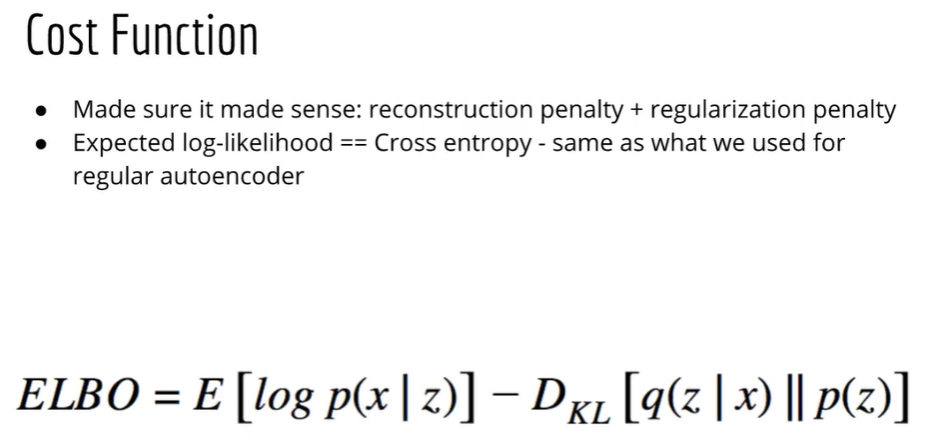

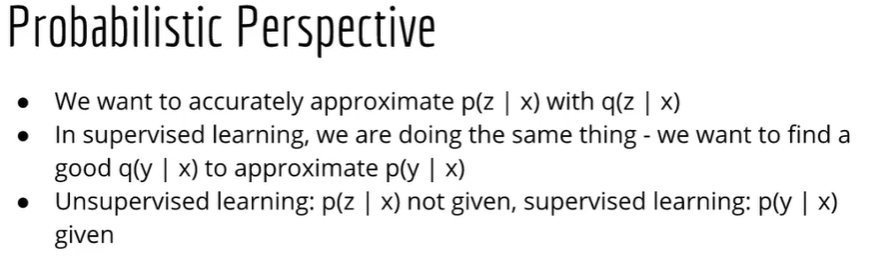

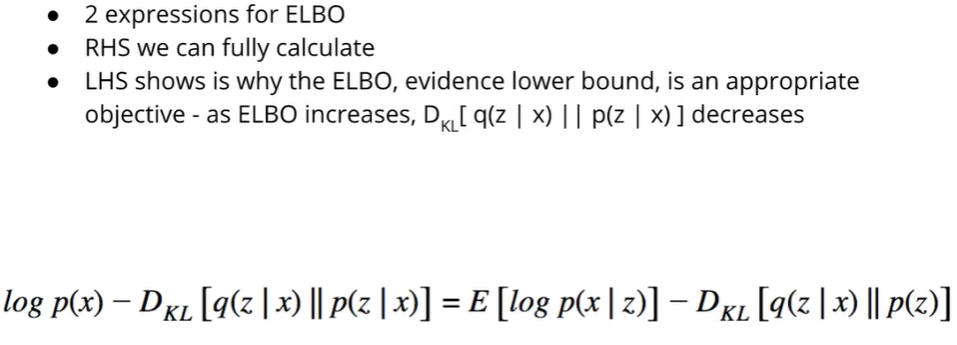